In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
from scipy import stats
import geopandas as gpd
%matplotlib inline
from sklearn import preprocessing

In [2]:
Model_III = pd.read_csv('Model III Delta 08-13.csv')

In [3]:
Model_III.head()

,Neighborhood-index,Adults Reporting Exercise in the Past 30 Days,Adults with Asthma in the Past 12 Months,Adults with High Cholesterol,Adults without a Smoke-Free Home Policy,Asthma Hospitalizations (Adults),Asthma Hospitalizations (Children 0 to 4 Yrs Old),Asthma Hospitalizations (Children 5 to 17 Yrs Old),Cigarette Smoking among Adults,Chronic Obstructive Pulmonary Disease Hospitalization
0,Bayside - Little Neck,0.033333,0.365854,0.180495,-0.096774,0.081081,0.543224,0.607735,-0.171642,0.025947
1,Bedford Stuyvesant - Crown Heights,0.058901,-0.890625,0.230132,0.372937,0.078453,0.042582,-0.009199,0.290476,-0.217956
2,Bensonhurst - Bay Ridge,-0.064801,0.000000,0.051702,0.061303,-0.193673,0.165584,0.000000,0.077670,-0.058596
3,Borough Park,0.071749,-0.042857,0.207116,0.011111,0.210544,0.109612,0.067039,-0.798246,0.033032
4,Canarsie - Flatlands,0.180593,-0.416667,0.184300,0.125000,0.062060,-0.264089,-0.495238,0.390244,-0.124864


In [12]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
hc = HillClimbSearch(Model_III, scoring_method=BicScore(Model_III))
best_model = hc.estimate()
print(best_model.edges())

[]


In [4]:
len(Model_III.columns)

10

In [5]:
X = Model_III.iloc[:,1:11]

## Gaussian Mixture Clustering -- Model III

In [6]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

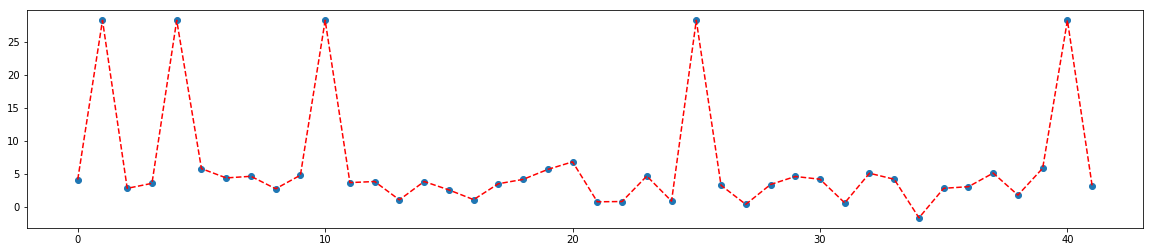

In [7]:
# score_samples function gives the log of the probability density of each data record given its cluster.
# Note that probability densities can exceed 1 (unlike probabilities of discrete data).
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X)) #gives each data record's log-likelihood. allows for direct anamoly detection
plt.plot(GM.score_samples(X),"r--")
plt.show()

In [8]:
# 5 most anomalous data points by log-likelihood (i.e. log probability density)
pd.DataFrame(GM.score_samples(X)).sort_values(0)[:5]

,0
34,-1.636656
27,0.402578
31,0.625390
21,0.792031
22,0.833108


In [9]:
Neighborhood_COPD = Model_III[['Neighborhood-index', 'Chronic Obstructive Pulmonary Disease  Hospitalization']]
Neighborhood_COPD.iloc[[34,27, 31, 21, 22],:]

#Model_I[6]

,Neighborhood-index,Chronic Obstructive Pulmonary Disease Hospitalization
34,Sunset Park,-0.122460
27,Port Richmond,-0.786517
31,Southeast Queens,0.120125
21,Jamaica,0.133152
22,Kingsbridge - Riverdale,0.390357


## K-means Model III

In [10]:
X_scaled = preprocessing.scale(X)

In [11]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=2,random_state=999)
scor=KM.fit_predict(X_scaled)

# distance to each cluster center
res=pd.DataFrame(KM.transform(X_scaled))
res.head()

,0,1
0,2.097196,3.351571
1,4.318163,2.855510
2,3.099059,2.307283
3,2.915323,3.324488
4,5.208994,3.510582


In [12]:
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X_scaled))),axis=1)
res.columns=list(range(2))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,cluster,score
27,5.916428,4.339659,1,4.339659
41,4.780823,4.280376,1,4.280376
18,3.754415,5.102781,0,3.754415
31,3.726292,4.528731,0,3.726292
34,4.063064,3.645671,1,3.645671


In [14]:
x = res.loc[:,"score"]
df_N = Model_III
df_N = df_N.reset_index()
df_N['K-means'] = x
df_K = df_N[['Neighborhood-index', 'Chronic Obstructive Pulmonary Disease  Hospitalization', 'K-means']]
df_K.nlargest(5, 'K-means')

,Neighborhood-index,Chronic Obstructive Pulmonary Disease Hospitalization,K-means
27,Port Richmond,-0.786517,4.339659
41,Willowbrook,-0.103976,4.280376
18,Greenwich Village - SoHo,0.225806,3.754415
31,Southeast Queens,0.120125,3.726292
34,Sunset Park,-0.122460,3.645671


In [15]:
y = Model_III.iloc[:,1:3]

In [16]:
y['cluster'] = (res.loc[:,"cluster"])

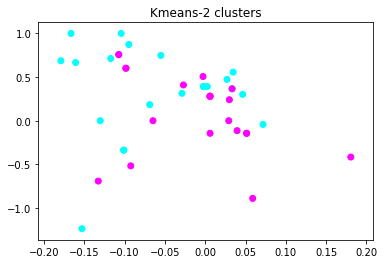

In [17]:
#plt.subplot(1,2,2)
plt.scatter(y.iloc[:,0], y.iloc[:,1], c=y['cluster'], cmap=plt.cm.cool)
#plt.xlabel('x1')
#plt.ylabel('x2')
#plt.xticks(())
#plt.yticks(())
plt.title("Kmeans-{} clusters".format(2))
plt.show()

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4,5]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=999)
    cluster_labels = km.fit_predict(y.iloc[:,0:2])
    #report average Silhouette score
    silhouette_avg = silhouette_score(y.iloc[:,0:2], cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.59476526546
For n_clusters =3, the average silhouette_score is :0.488766692282
For n_clusters =4, the average silhouette_score is :0.574409503523
For n_clusters =5, the average silhouette_score is :0.570337468513


### Isolation Forest Modeling -- Model III

In [38]:
from sklearn.ensemble import IsolationForest

In [39]:
clf = IsolationForest(max_samples=50, random_state=123)
clf.fit_predict(X)
IsoForest = (clf.score_samples(X))

C:\Users\aniha\Anaconda3\envs\TwentySevenVersion\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\aniha\Anaconda3\envs\TwentySevenVersion\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\aniha\Anaconda3\envs\TwentySevenVersion\lib\site-packages\sklearn\ensemble\iforest.py:250: UserWarning: max_samples (50) is greater than the total number of samples (42). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
C:\Users\aniha\Anaconda3\envs\TwentySevenVersion\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 

In [40]:
#Iso_score = GM.score_samples(Data_Numeric.iloc[:,1:32])
df_I = Model_III
df_I = df_I.reset_index()
df_I['IsoFoScore'] = IsoForest
df_I = df_I[['Neighborhood-index','IsoFoScore']]
df_I.nsmallest(5, 'IsoFoScore')

,Neighborhood-index,IsoFoScore
27,Port Richmond,-0.519062
41,Willowbrook,-0.507593
4,Canarsie - Flatlands,-0.492987
13,Flushing - Clearview,-0.484400
10,East Flatbush - Flatbush,-0.477965


## LOF Clustering -- Model III

In [19]:
from sklearn.neighbors import LocalOutlierFactor

# fit the model
clf_LOF = LocalOutlierFactor(n_neighbors=5)
y_pred = clf_LOF.fit_predict(X)
LOF = (clf_LOF.negative_outlier_factor_)

C:\Users\aniha\Anaconda3\envs\TwentySevenVersion\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [20]:
# fit the model
df_LOF = Model_III
df_LOF = df_LOF.reset_index()
df_LOF['LOF_Score'] = LOF
df_LOF = df_LOF[['Neighborhood-index', 'Chronic Obstructive Pulmonary Disease  Hospitalization', 'LOF_Score']]
df_LOF.nsmallest(5, 'LOF_Score')

,Neighborhood-index,Chronic Obstructive Pulmonary Disease Hospitalization,LOF_Score
27,Port Richmond,-0.786517,-1.738410
41,Willowbrook,-0.103976,-1.510757
34,Sunset Park,-0.122460,-1.327384
18,Greenwich Village - SoHo,0.225806,-1.293548
16,Gramercy Park - Murray Hill,-0.003549,-1.232164


In [21]:
X_reshape = X.values.reshape(-2,2)

In [22]:
len(X_reshape)

189

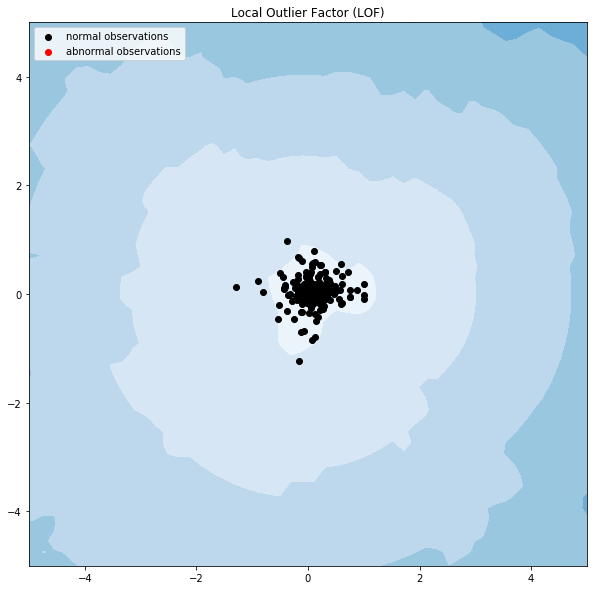

In [25]:
# fit the model
clf_LOF = LocalOutlierFactor(n_neighbors=7)
y_pred = clf_LOF.fit_predict(X_reshape)
#y_pred_outliers = y_pred[200:]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
Z = clf_LOF._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))


plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X_reshape[:189, 0], X_reshape[:189, 1], c='black')
b = plt.scatter(X_reshape[189:, 0], X_reshape[189:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

## DBSCAN -- Model I

In [47]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
import sklearn.datasets as data
import sklearn.cluster as cluster
import time
from sklearn import cluster, datasets

In [48]:
def visuDB(data,eps,min_samples):
    db = DBSCAN(eps, min_samples).fit(X_reshape)
    plt.figure(figsize=(6,6))
    plt.scatter(X_reshape[:,0],X_reshape[:,1],c=db.labels_,s=10)
    print "Proportion of unclustered points=",(1*(db.labels_ < 0)).mean()
    plt.show()

Proportion of unclustered points= 0.0


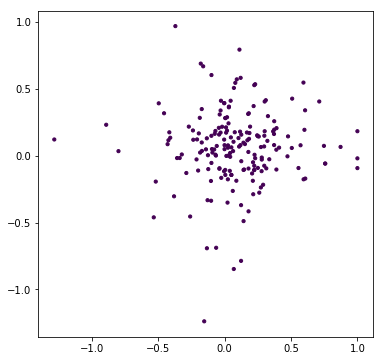

In [49]:
visuDB(X_reshape,0.5,7)

In [50]:
# your code here

total_num_samples = len(X_reshape[:,0])
max_eps = max(np.max(X_reshape[:,0])-np.min(X_reshape[:,0]),np.max(X_reshape[:,1])-np.min(X_reshape[:,1]))

for eps in np.logspace(np.log10(max_eps)-3,np.log10(max_eps),10):
    for min_samples in np.linspace(40,800,40,endpoint=True):
        db = DBSCAN(eps, min_samples).fit(X_reshape)
        num_clustered = len(db.labels_[db.labels_ >= 0])
        if (num_clustered > 0) & (num_clustered < 0.1*total_num_samples):
            dbb=db
            plt.figure(figsize=(8,8))
            print "eps =", eps, ", min_samples =", min_samples, ", num_detected_points =", len(db.labels_[db.labels_ >= 0])
            
            # evaluation
            num_correct_clustered = len(db.labels_[0:100][db.labels_[0:100] >= 0])
            print "precision=",1.0*num_correct_clustered/num_clustered,"recall=",1.0*num_correct_clustered/100.0
            
            plt.scatter(X_reshape[:,0],X_reshape[:,1],c=db.labels_,s=10,cmap=plt.cm.cool)
            plt.show()